In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path = r"C:\Users\achra\Downloads\Final_ERCOT_Energy_Prices.csv"
df = pd.read_csv(file_path)
df.head()

,DeliveryDate,HourEnding,SettlementPoint,SettlementPointPrice,DSTFlag
0,01/02/2023,01:00,AEEC,9.56,N
1,01/02/2023,01:00,AGUAYO_UNIT1,8.99,N
2,01/02/2023,01:00,AJAXWIND_RN,9.72,N
3,01/02/2023,01:00,ALGOD_ALL_RN,-4.31,N
4,01/02/2023,01:00,ALVIN_RN,5.65,N


In [4]:
df = df[df['SettlementPoint'].isin(['LZ_HOUSTON', 'LZ_WEST', 'LZ_SOUTH', 'LZ_NORTH'])]
df.head()

,DeliveryDate,HourEnding,SettlementPoint,SettlementPointPrice,DSTFlag
449,01/02/2023,01:00,LZ_HOUSTON,9.57,N
451,01/02/2023,01:00,LZ_NORTH,9.91,N
453,01/02/2023,01:00,LZ_SOUTH,0.82,N
454,01/02/2023,01:00,LZ_WEST,15.94,N
1270,01/02/2023,02:00,LZ_HOUSTON,5.02,N


In [5]:
df.rename(columns={'SettlementPoint': 'Region'}, inplace=True)
df.head()

,DeliveryDate,HourEnding,Region,SettlementPointPrice,DSTFlag
449,01/02/2023,01:00,LZ_HOUSTON,9.57,N
451,01/02/2023,01:00,LZ_NORTH,9.91,N
453,01/02/2023,01:00,LZ_SOUTH,0.82,N
454,01/02/2023,01:00,LZ_WEST,15.94,N
1270,01/02/2023,02:00,LZ_HOUSTON,5.02,N


In [7]:
import plotly.express as px

avg_price_by_hour = df.groupby(['HourEnding', 'Region'])['SettlementPointPrice'].mean().unstack()

fig = px.line(avg_price_by_hour, labels={
    'value': 'Average Settlement Point Price',
    'HourEnding': 'Hour Ending',
    'variable': 'Region'
}, title='Average Settlement Point Price by Hour Ending and Region')

fig.update_layout(
    xaxis_title='Hour Ending',
    yaxis_title='Average Settlement Point Price',
    legend_title='Region',
    template='plotly_white',
    height=800  # Increase the height of the figure
)

fig.show()

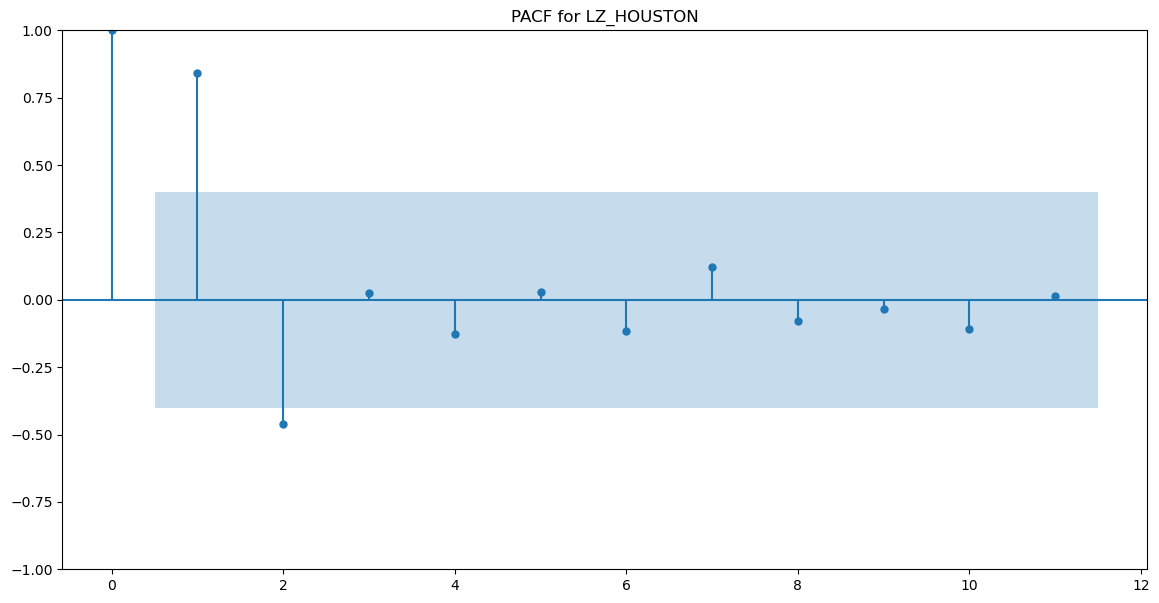

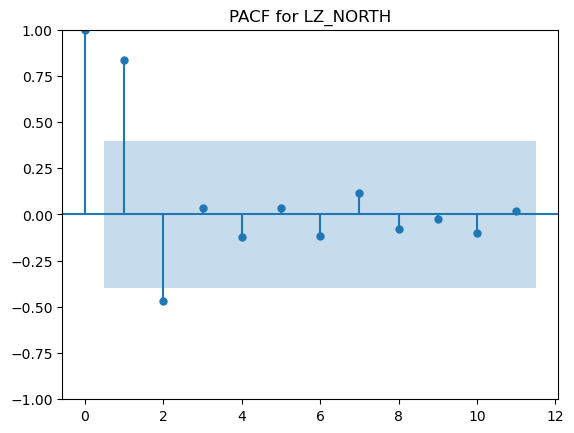

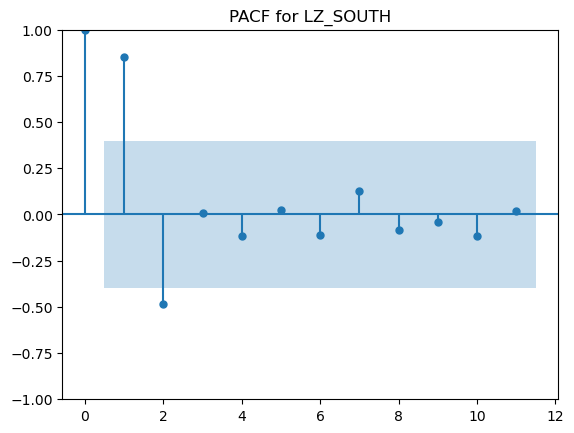

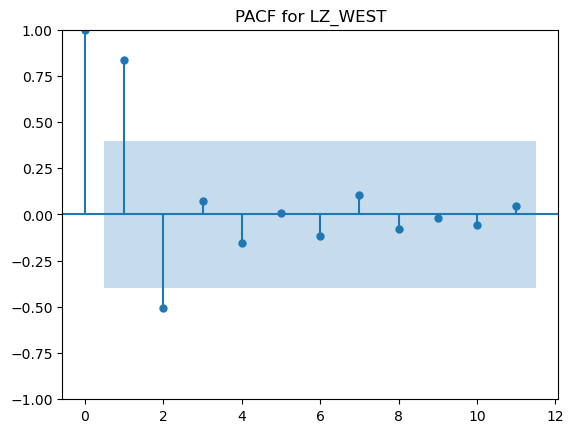

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(14, 7))
for region in avg_price_by_hour.columns:
    plot_pacf(avg_price_by_hour[region], lags=11, ax=plt.gca(), title=f'PACF for {region}')
    plt.show()

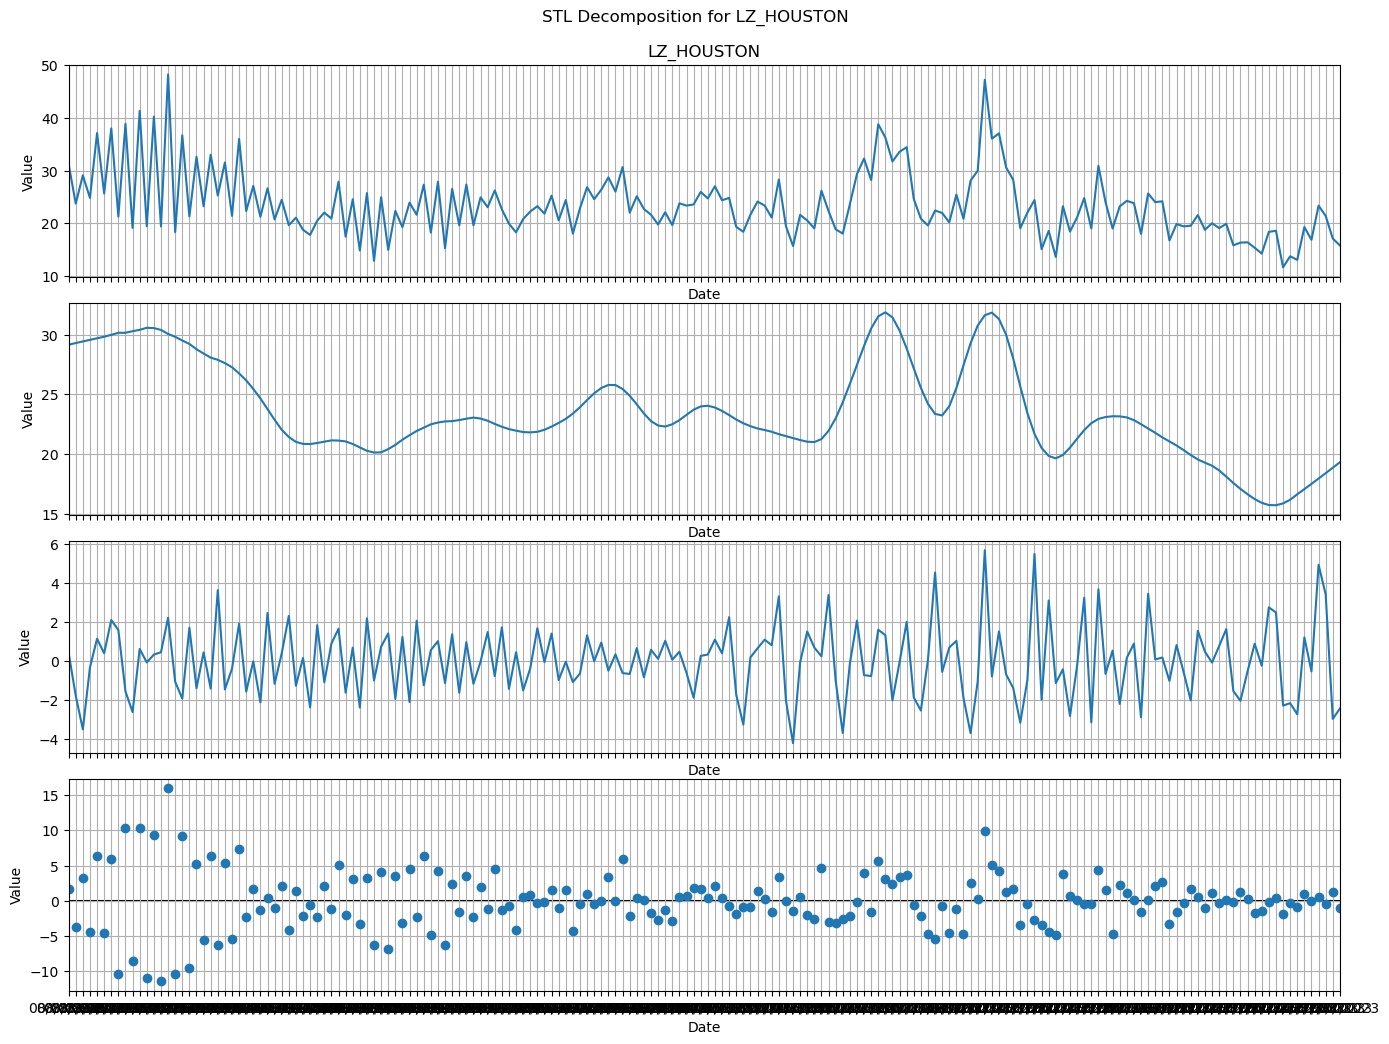

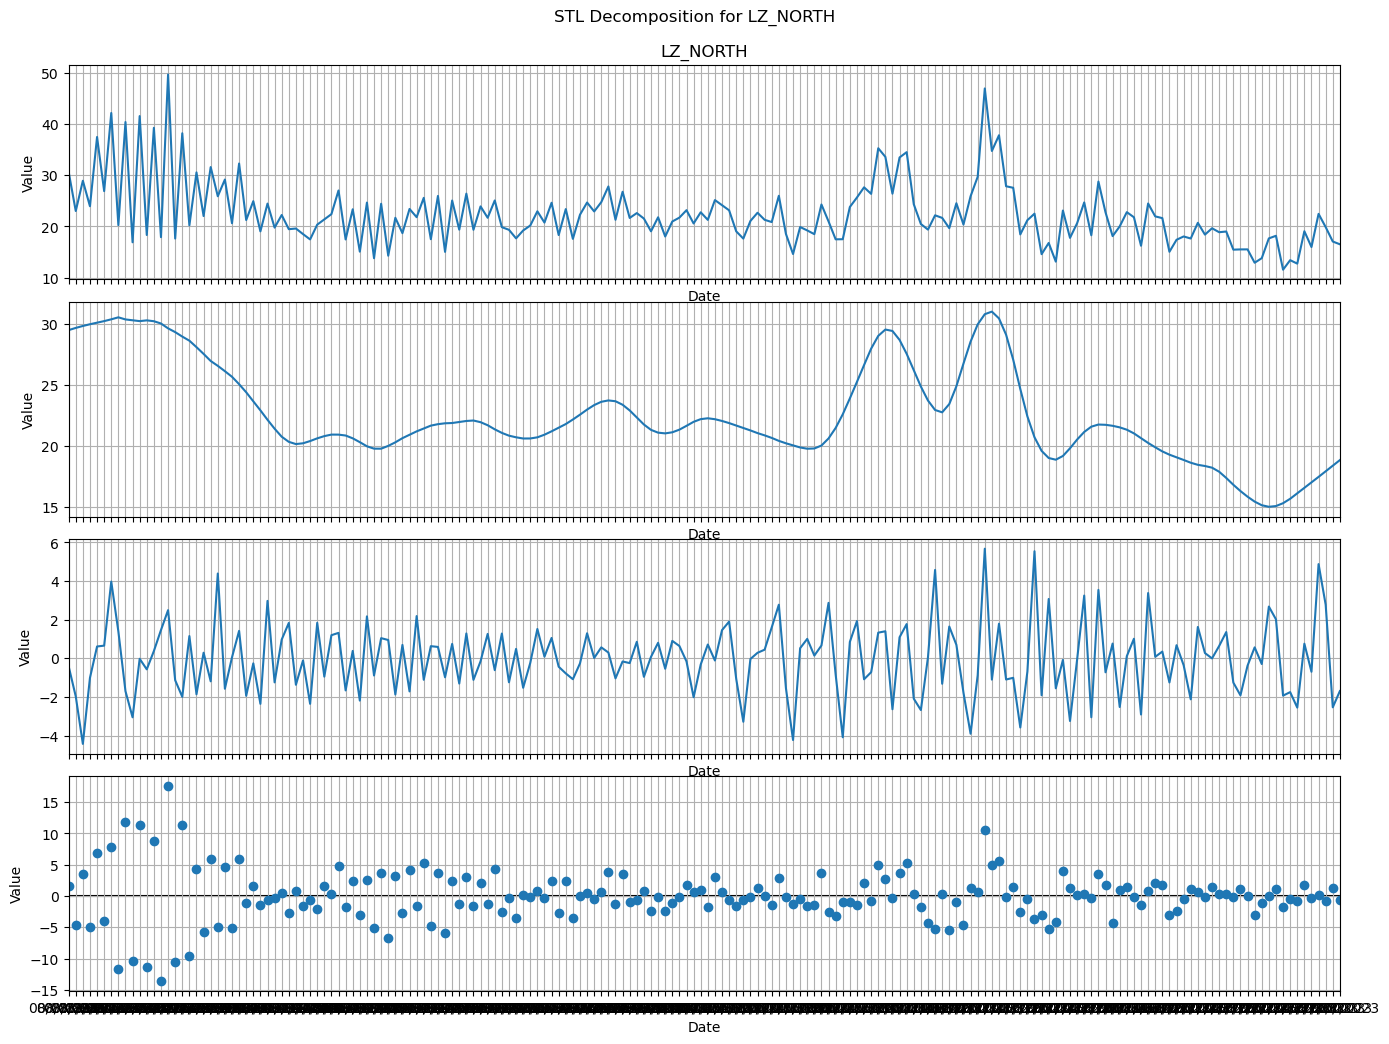

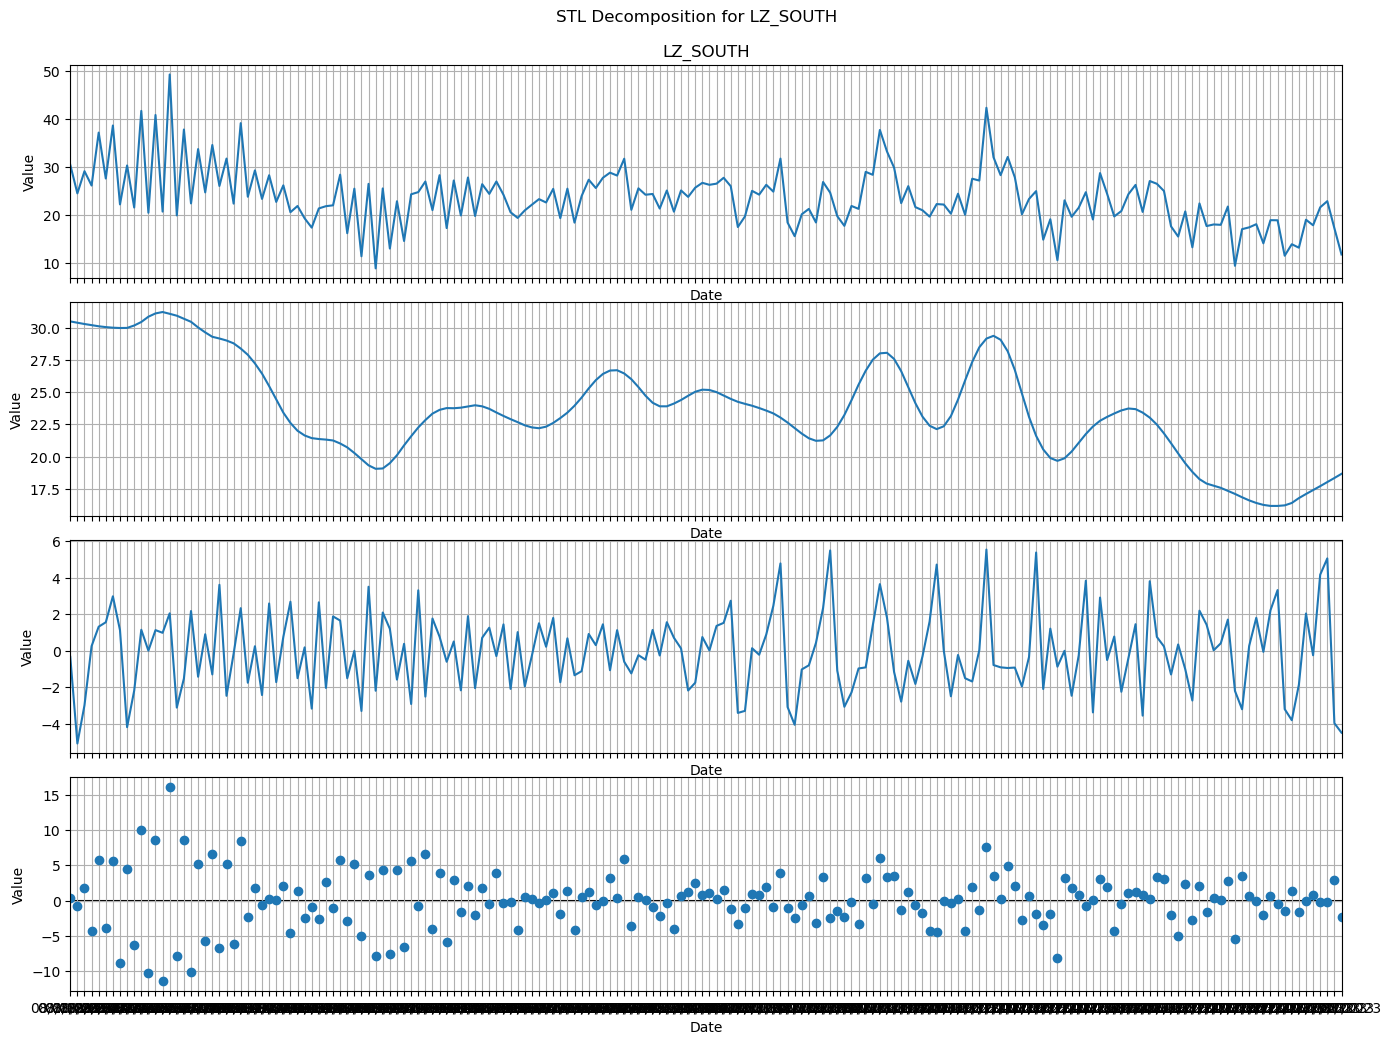

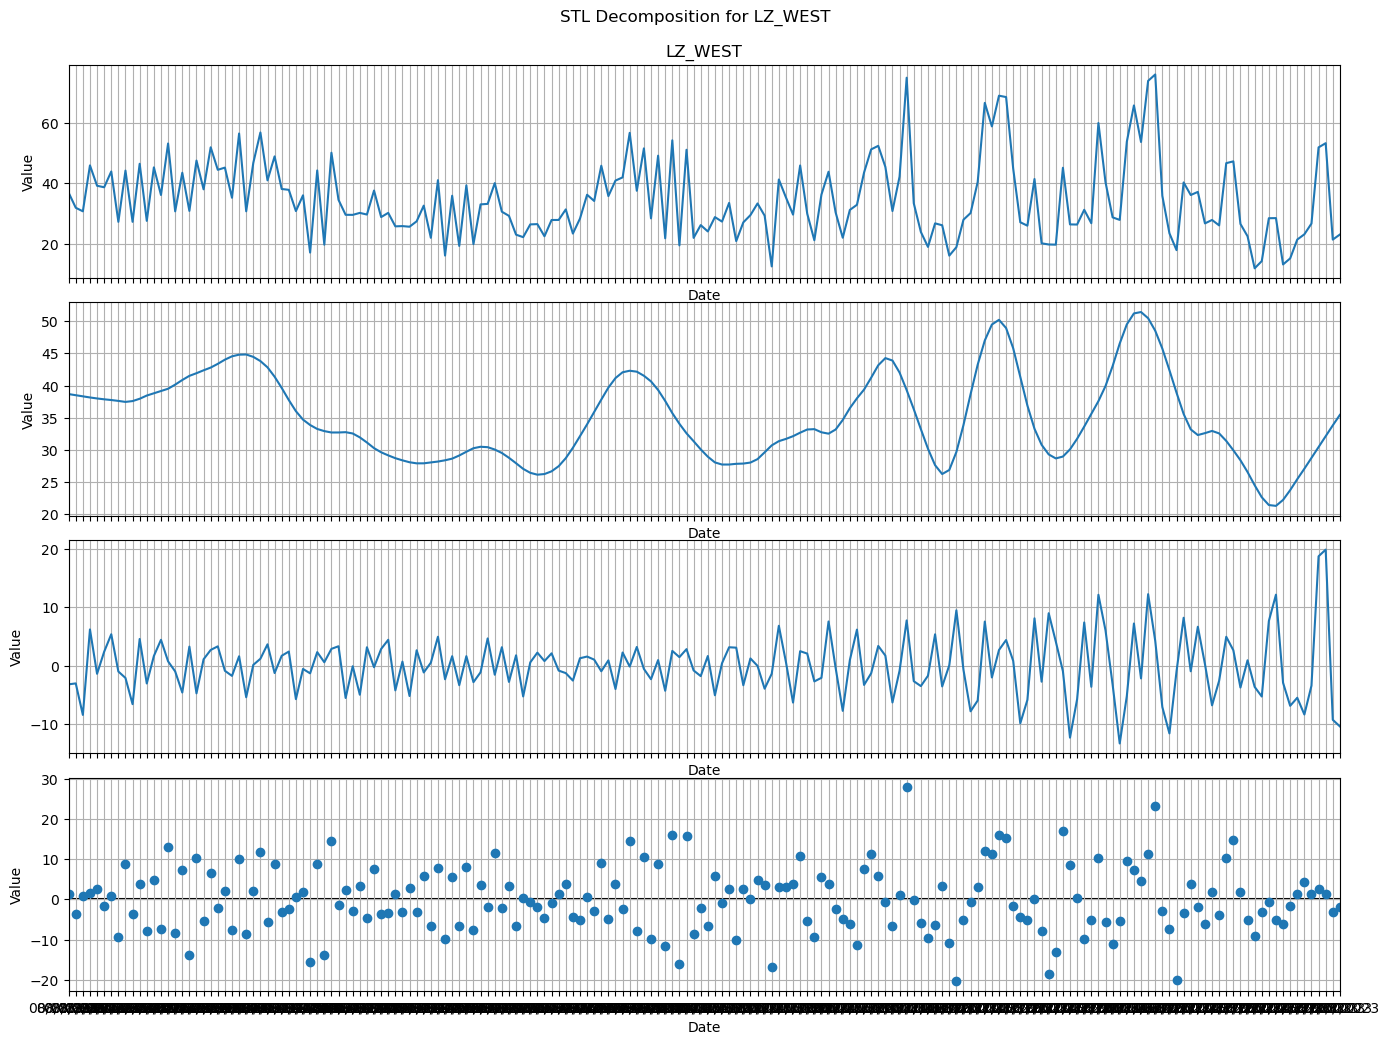

In [35]:
from statsmodels.tsa.seasonal import STL

last_month_data = daily_avg_price.iloc[-180:]

for region in last_month_data.columns:
    stl = STL(last_month_data[region], period=7)
    result = stl.fit()

    fig = result.plot()
    fig.set_size_inches(14, 10)  
    fig.tight_layout()  
    for ax in fig.axes:
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.grid(True)

    plt.suptitle(f'STL Decomposition for {region}', y=1.02)
    plt.show()
